In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.anova import AnovaRM
import pylab

In [29]:
plot_key = pd.read_excel('../Data/ID and Plots.xlsx', engine='openpyxl')
# plot_key = plot_key[['Sample ID', 'Plot', 'ID', 'Block', 'Water', 'Nrate', 'Direction']]
plot_key.head()

,ID,Plot,Nitrogen,Water,Block,Water rate (%ET),Nrate (llbs/acre)
0,114,1N,4,1,1,100,155
1,114,1S,4,1,1,100,155
2,111,2N,1,1,1,100,20
3,111,2S,1,1,1,100,20
4,115,3N,5,1,1,100,200


In [30]:
soil_key = pd.read_excel('../Sequencing/Soil key/Soil DNA extraction key.xlsx', engine='openpyxl')
soil_key = soil_key[soil_key['Skipping'] != 'Yes']
soil_key = soil_key[soil_key['Quality'] != 'Failed']
soil_key = soil_key[['Sample name','Sample date','Plot']]
soil_key.rename({'Plot':'Sample ID'}, axis = 1, inplace = True)
soil_key = soil_key[~soil_key['Sample ID'].isnull()]
soil_key[['Plot', 'ID', 'Nitrogen', 'Water', 'Block', 'Direction']] = np.nan
soil_key.head()

,Sample name,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction
1,2,2021-07-27,15N,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2021-07-27,32N,NaN,NaN,NaN,NaN,NaN,NaN
14,15,2021-07-27,8N,NaN,NaN,NaN,NaN,NaN,NaN
15,16,2021-07-27,2S,NaN,NaN,NaN,NaN,NaN,NaN
18,19,2021-07-27,30N,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
for index, row in soil_key.iterrows():
    if (row['Sample ID'] == 'King Fischer') | (row['Sample ID'] == 'stove pipe prairie') | (row['Sample ID'] == 'NaN'):
        continue
    tmp_data = plot_key[plot_key['Plot'] == row['Sample ID']]
    soil_key.loc[index, 'Plot'] = tmp_data['Plot'].iloc[0]
    soil_key.loc[index, 'ID'] = tmp_data['ID'].iloc[0]
    soil_key.loc[index, 'Block'] = tmp_data['Block'].iloc[0]
    soil_key.loc[index, 'Water'] = tmp_data['Water'].iloc[0]
    soil_key.loc[index, 'Nitrogen'] = tmp_data['Nitrogen'].iloc[0]
soil_key['Direction'] = [x[-1:] for x in soil_key['Sample ID']]
soil_key.set_index('Sample name', inplace = True)

In [53]:
number_of_sheets = 8
dates = ['6/3/2021','6/15/2021','6/30/2021','7/14/2021','7/27/2021','8/10/2021','8/24/2021','9/23/2021']
sheets = []
moisture_data = []
for i in range(number_of_sheets):
    sheets.append(pd.read_excel('../Data/Soil moisture/Moisture_All_Dates_2021.xlsx', sheet_name=i, engine='openpyxl'))
    moisture_data.append(pd.DataFrame(sheets[i]))
    moisture_data[i].drop(['ID','Adjusted'], inplace = True, axis = 1)
    moisture_data[i]['Date'] = pd.to_datetime(dates[i])
    moisture_data[i]['Date'] = [x.strftime('%m-%d') for x in moisture_data[i]['Date']]
moisture_data_all = pd.concat(moisture_data)
moisture_data_all = moisture_data_all[moisture_data_all['Date'].isin(data_joined_simple['Sample date'])]
print(moisture_data_all.shape)
moisture_data_all.head()

(180, 3)


,Plot,Moisture %,Date
0,2N,0.179104,06-15
1,2S,0.150575,06-15
2,3N,0.165308,06-15
3,3S,0.178447,06-15
4,6N,0.184615,06-15


In [50]:
data = pd.read_excel('/mnt/c/Users/bo.stevens/OneDrive - USDA/2022/NxWater Akron/Data/qPCR/NxW MinION master list - 2.xlsx', sheet_name = 'qPCR', engine='openpyxl')
data = data[~data['Sample name'].isnull()]
data.set_index('Sample name', inplace = True)
data.head()

,Study,Thermal cycler,LightCycler File Name,PCR Method,Gene,primer1,primer2,PCR Slope rep1,PCR Slope rep2,PCR Slope rep3,...,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
Sample name,,,,,,,,,,,,,,,,,,,,,
2,NxW,Roche LightCycler 96,24Feb22.NxW.miseq.16S.qPCR.10uLrxn.A1/2/3,"minION 16S, MiSeq 16S for qPCR",full 16S,"minION 27F, MiSeq 16SF","minION 1492R, MiSeq 16SR",0.35,0.37,0.35,...,159735.478048,7.0,1.118000e+06,NaN,NaN,16S 454 qPCR,Preincubation,1.0,95C,510sec
6,NxW,Roche LightCycler 96,24Feb22.NxW.miseq.16S.qPCR.10uLrxn.A1/2/3,"minION 16S, MiSeq 16S for qPCR",full 16S,"minION 27F, MiSeq 16SF","minION 1492R, MiSeq 16SR",0.38,0.38,0.37,...,26595.744681,100.0,2.659574e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NxW,Roche LightCycler 96,24Feb22.NxW.miseq.16S.qPCR.10uLrxn.A1/2/3,"minION 16S, MiSeq 16S for qPCR",full 16S,"minION 27F, MiSeq 16SF","minION 1492R, MiSeq 16SR",0.36,0.37,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NxW,Roche LightCycler 96,24Feb22.NxW.miseq.16S.qPCR.10uLrxn.A1/2/3,"minION 16S, MiSeq 16S for qPCR",full 16S,"minION 27F, MiSeq 16SF","minION 1492R, MiSeq 16SR",0.37,0.37,0.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NxW,Roche LightCycler 96,24Feb22.NxW.miseq.16S.qPCR.10uLrxn.A1/2/3,"minION 16S, MiSeq 16S for qPCR",full 16S,"minION 27F, MiSeq 16SF","minION 1492R, MiSeq 16SR",0.37,0.36,0.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_joined = pd.concat([soil_key, data[['Conc (copies / g soil FW)']]], axis = 1)
data_joined = data_joined[~data_joined['Nitrogen'].isin([2,3])]
data_joined = data_joined[data_joined['Sample date'] != '2022-02-20']
data_joined = data_joined[~data_joined['Sample date'].isnull()]
data_joined['Value'] = data_joined['Conc (copies / g soil FW)']
data_joined = data_joined[data_joined['Value'] > 0]
data_joined['Sample date'] = [x.strftime('%m-%d') for x in data_joined['Sample date']]
# averaging N and S
data_joined_simple = data_joined.copy()
data_joined_simple = data_joined_simple.drop(['Sample ID','Value','ID'], axis = 1)


print(data_joined_simple.shape)
data_joined_simple.head()

(169, 7)


,Sample date,Plot,Nitrogen,Water,Block,Direction,Conc (copies / g soil FW)
Sample name,,,,,,,
2,07-27,15N,5.0,2.0,2.0,N,4.822156e+09
6,07-27,32N,1.0,1.0,3.0,N,1.094005e+09
15,07-27,8N,1.0,2.0,1.0,N,9.491052e+08
16,07-27,2S,1.0,1.0,1.0,S,8.512997e+08
19,07-27,30N,1.0,2.0,3.0,N,1.783052e+09


In [55]:
final_df = pd.merge(data_joined_simple, moisture_data_all, right_on=['Plot','Date'], left_on=['Plot','Sample date'])
# filled in missing samples 32 N and S, 7-27 with average for that nitrogen, water, and date (0.2)
# print(final_df.groupby(['Nitrogen','Water','Date']).mean())
# print(final_df['Moisture %'].isna().sum())
final_df['Conc (copies / g soil DW)'] = (1 - final_df['Moisture %'])*final_df['Conc (copies / g soil FW)']
final_df['Value_DW'] = final_df['Conc (copies / g soil DW)']
final_df['Value_FW'] = final_df['Conc (copies / g soil FW)']
final_df['DW_log'] = np.log(final_df['Value_DW'])
final_df['FW_log'] = np.log(final_df['Value_FW'])
print(final_df.shape)
final_df.head()

(169, 14)


,Sample date,Plot,Nitrogen,Water,Block,Direction,Conc (copies / g soil FW),Moisture %,Date,Conc (copies / g soil DW),Value_DW,Value_FW,DW_log,FW_log
0,07-27,15N,5.0,2.0,2.0,N,4.822156e+09,0.085239,07-27,4.411120e+09,4.411120e+09,4.822156e+09,22.207394,22.296487
1,07-27,32N,1.0,1.0,3.0,N,1.094005e+09,0.200000,07-27,8.752042e+08,8.752042e+08,1.094005e+09,20.589968,20.813111
2,07-27,8N,1.0,2.0,1.0,N,9.491052e+08,0.077007,07-27,8.760179e+08,8.760179e+08,9.491052e+08,20.590897,20.671030
3,07-27,2S,1.0,1.0,1.0,S,8.512997e+08,0.216867,07-27,6.666805e+08,6.666805e+08,8.512997e+08,20.317821,20.562275
4,07-27,30N,1.0,2.0,3.0,N,1.783052e+09,0.034126,07-27,1.722203e+09,1.722203e+09,1.783052e+09,21.266870,21.301592


In [56]:
set(data_joined_simple['Sample date'])

{'06-15', '06-30', '07-27', '08-10', '09-23'}

In [57]:
data_joined_simple.groupby(['Sample date']).size()

Sample date
06-15    36
06-30    33
07-27    35
08-10    34
09-23    31
dtype: int64

<AxesSubplot:xlabel='Nitrogen', ylabel='Conc (copies / g soil DW)'>

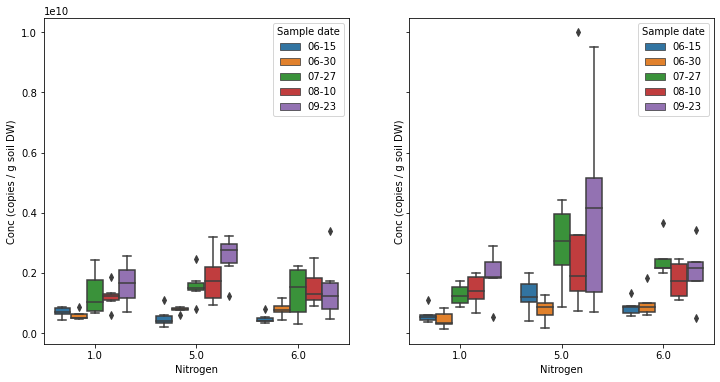

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
sns.boxplot(y = 'Conc (copies / g soil DW)', x = 'Nitrogen', hue = 'Sample date', 
            hue_order = ['06-15', '06-30', '07-27', '08-10', '09-23'], data = final_df[final_df['Water'] == 1], ax = axes[0])
sns.boxplot(y = 'Conc (copies / g soil DW)', x = 'Nitrogen', hue = 'Sample date', 
            hue_order = ['06-15', '06-30', '07-27', '08-10', '09-23'], data = final_df[final_df['Water'] == 2], ax = axes[1])

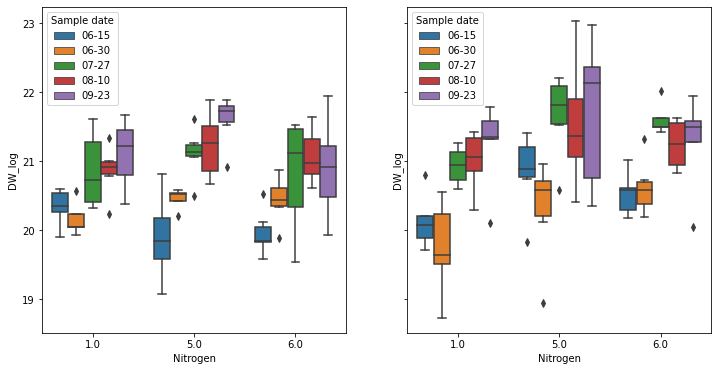

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
sns.boxplot(y = 'DW_log', x = 'Nitrogen', hue = 'Sample date', 
            hue_order = ['06-15', '06-30', '07-27', '08-10', '09-23'], data = final_df[final_df['Water'] == 1], ax = axes[0])
sns.boxplot(y = 'DW_log', x = 'Nitrogen', hue = 'Sample date', 
            hue_order = ['06-15', '06-30', '07-27', '08-10', '09-23'], data = final_df[final_df['Water'] == 2], ax = axes[1])
# axes[0].set(yscale='log')
# plt.ylim([0,25])
plt.savefig('../Figures/qPCR_all_water.jpg', dpi = 300, bbox_inches = 'tight')

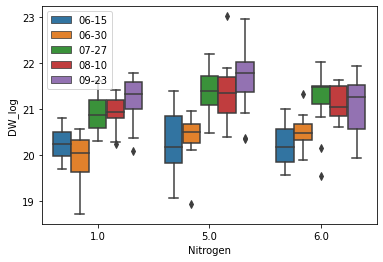

In [80]:
sns.boxplot(y = 'DW_log', x = 'Nitrogen', hue = 'Sample date', 
            hue_order = ['06-15', '06-30', '07-27', '08-10', '09-23'], data = final_df)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.savefig('../Figures/qPCR_all_nitrogen.jpg', dpi = 300, bbox_inches = 'tight')

# Check for assumptions

In [61]:
# normality test
# Plot residuals
stat, p = shapiro(final_df['DW_log'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.994, p=0.773
Sample looks Gaussian (fail to reject H0)


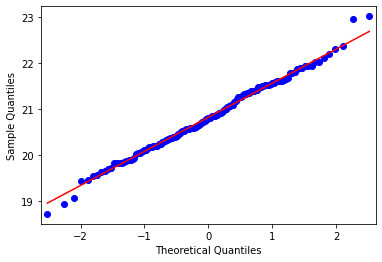

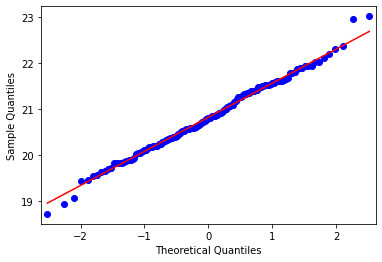

In [62]:
# QQ plot
sm.qqplot(final_df['DW_log'], line = 's')

# ANOVAs

In [63]:
model = AnovaRM(final_df, 'DW_log', 'Date', within = ['Nitrogen','Water'], aggregate_func='mean')
results = model.fit()
print(results)

                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
Nitrogen        7.7254 2.0000 8.0000 0.0135
Water           5.0552 1.0000 4.0000 0.0878
Nitrogen:Water  5.1508 2.0000 8.0000 0.0365



In [65]:
final_df.head()

,Sample date,Plot,Nitrogen,Water,Block,Direction,Conc (copies / g soil FW),Moisture %,Date,Conc (copies / g soil DW),Value_DW,Value_FW,DW_log,FW_log
0,07-27,15N,5.0,2.0,2.0,N,4.822156e+09,0.085239,07-27,4.411120e+09,4.411120e+09,4.822156e+09,22.207394,22.296487
1,07-27,32N,1.0,1.0,3.0,N,1.094005e+09,0.200000,07-27,8.752042e+08,8.752042e+08,1.094005e+09,20.589968,20.813111
2,07-27,8N,1.0,2.0,1.0,N,9.491052e+08,0.077007,07-27,8.760179e+08,8.760179e+08,9.491052e+08,20.590897,20.671030
3,07-27,2S,1.0,1.0,1.0,S,8.512997e+08,0.216867,07-27,6.666805e+08,6.666805e+08,8.512997e+08,20.317821,20.562275
4,07-27,30N,1.0,2.0,3.0,N,1.783052e+09,0.034126,07-27,1.722203e+09,1.722203e+09,1.783052e+09,21.266870,21.301592


In [66]:
final_df.dtypes

Sample date                   object
Plot                          object
Nitrogen                     float64
Water                        float64
Block                        float64
Direction                     object
Conc (copies / g soil FW)    float64
Moisture %                   float64
Date                          object
Conc (copies / g soil DW)    float64
Value_DW                     float64
Value_FW                     float64
DW_log                       float64
FW_log                       float64
dtype: object

# Confidence intervals (not updated, probably not necessary)

In [20]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [21]:
# # This method takes a more than 10 minutes ... ? - I think I fixed that
# dates = []
# waters = []
# nrates = []
# means = []
# lowers = []
# uppers = []
# for date in ['07-27', '08-10', '09-23']:
#     for nrate in [1,5,6]:
#         for water in [1,2]:
#             print(date, nrate)
#             mean, lower, upper = mean_confidence_interval(data_joined[(data_joined['Sample date'] == date) 
#                                                                       & (data_joined['Nitrogen'] == nrate)
#                                                                      & (data_joined['Water'] == water)]['Conc (copies / g soil FW)'])
#             dates.append(date)
#             waters.append(water)
#             nrates.append(nrate)
#             means.append(mean)
#             lowers.append(lower)
#             uppers.append(upper)
# stats_df_nitrogen_final = pd.DataFrame({'Date':dates, 'Waters': waters, 'Nrate':nrates, 'Mean':means, 'Lower':lowers, 'Upper':uppers})

In [22]:
# stats_df_nitrogen_final.to_csv('../Data/Statistics/qpcr_stats_nitrogen.csv')

In [23]:
# stats_df_nitrogen_final

# Linear regression of qPCR (doesn't seem appropriate)
Doesn't seem to be working with non-log data

In [24]:
# https://towardsdatascience.com/how-to-run-linear-mixed-effects-models-in-python-jupyter-notebooks-4f8079c4b589

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [26]:
final_df_numeric = final_df.copy()
final_df_numeric['Nitrogen'] = final_df_numeric['Nitrogen'].replace({1.0: 20, 2.0: 65, 3.0:110, 4.0:155, 5.0:200, 6.0:245})
final_df_numeric['Water'] = final_df_numeric['Water'].replace({1.0: 100, 2.0: 70})
final_df_numeric.head()

,Sample date,Plot,Nitrogen,Water,Block,Direction,Conc (copies / g soil FW),Moisture %,Date,Conc (copies / g soil DW),Value_DW,Value_FW,DW_log,FW_log
0,07-27,15N,200.0,70.0,2.0,N,4.934823e+09,0.085239,07-27,4.514183e+09,4.514183e+09,4.934823e+09,22.230490,22.319583
1,07-27,32N,20.0,100.0,3.0,N,1.094005e+09,0.200000,07-27,8.752042e+08,8.752042e+08,1.094005e+09,20.589968,20.813111
2,07-27,8N,20.0,70.0,1.0,N,9.491052e+08,0.077007,07-27,8.760179e+08,8.760179e+08,9.491052e+08,20.590897,20.671030
3,07-27,2S,20.0,100.0,1.0,S,8.512997e+08,0.216867,07-27,6.666805e+08,6.666805e+08,8.512997e+08,20.317821,20.562275
4,07-27,30N,20.0,70.0,3.0,N,1.783052e+09,0.034126,07-27,1.722203e+09,1.722203e+09,1.783052e+09,21.266870,21.301592


<AxesSubplot:xlabel='DW_log', ylabel='Nitrogen'>

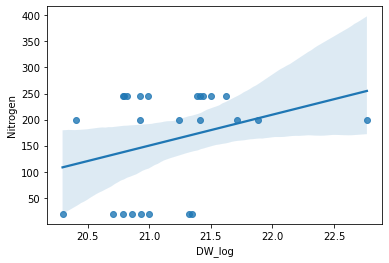

In [27]:
sns.regplot(y = 'Nitrogen', x = 'DW_log', data = final_df_numeric[final_df_numeric['Date'] == '08-10'])

In [28]:
md = smf.mixedlm('Water ~ DW_log', final_df_numeric, groups=final_df_numeric['Date'], re_formula='~Nitrogen')
mdf = md.fit(method=['lbfgs'])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Water    
No. Observations:      82         Method:                REML     
No. Groups:            3          Scale:                 216.7512 
Min. group size:       24         Log-Likelihood:        -344.6639
Max. group size:       33         Converged:             No       
Mean group size:       27.3                                       
------------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            239.980   72.981  3.288 0.001  96.941 383.019
DW_log                -7.418    3.460 -2.144 0.032 -14.199  -0.636
Group Var             32.585                                      
Group x Nitrogen Cov  -0.038                                      
Nitrogen Var           0.842                                      



/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 48.146330
  warnings.warn(msg, ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [29]:
md = smf.mixedlm('Nitrogen ~ DW_log', final_df_numeric, groups=final_df_numeric['Date'], re_formula='~Water')
mdf = md.fit(method=['lbfgs'])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Nitrogen 
No. Observations:      82          Method:                 REML     
No. Groups:            3           Scale:                  8094.4982
Min. group size:       24          Log-Likelihood:         -478.1509
Max. group size:       33          Converged:              No       
Mean group size:       27.3                                         
--------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept         -1261.073 1499.624 -0.841 0.400 -4200.281 1678.135
DW_log               66.441   72.510  0.916 0.360   -75.677  208.558
Group Var          4825.209  831.280                                
Group x Water Cov   -59.744    7.488                                
Water Var             0.751    0.066              

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 318.074819
  warnings.warn(msg, ConvergenceWarning)
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [30]:
md = smf.mixedlm('Nitrogen ~ DW_log', final_df_numeric, groups=final_df_numeric['Water'], re_formula='~Date')
mdf = md.fit(method=['lbfgs'])
print(mdf.summary())

                       Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          Nitrogen 
No. Observations:            82               Method:                      REML     
No. Groups:                  2                Scale:                       8038.0688
Min. group size:             39               Log-Likelihood:              -478.1056
Max. group size:             43               Converged:                   Yes      
Mean group size:             41.0                                                   
------------------------------------------------------------------------------------
                                    Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------
Intercept                         -1317.630  533.878 -2.468 0.014 -2364.012 -271.248
DW_log                               69.262   25.752  2.690 0.007    18.789  119.736
Grou

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Machine learning

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [174]:
# Predicting Nitrogen first, then water, then maybe both
# Could possibly use linear variables for nitrogen and water

In [ ]:
# start = time.time()
# accuracy_list = []
# random_chance_list = []
# for i in range(50):
#     X_train, X_test, Y_train, Y_test = train_test_split(rf_df[anova_df.head(n = 500)['Columns'].values].values,
#                                                         map_df[map_df.index.isin(rf_df.index)]['Landform'].values, test_size=0.3, random_state=i)
#     param_grid = { 
#         'n_estimators': [200, 500],
#         'max_features': ['auto', 'sqrt', 'log2'],
#         'max_depth' : [2,3,4,5,6,7,8,9,10],
#         'criterion' :['gini', 'entropy']
#     }
#     rfc=RandomForestClassifier(random_state=42)
#     CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#     CV_rfc.fit(X_train, Y_train)
#     predicted = CV_rfc.predict(X_test)
# end = time.time()
# print(end - start)